In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import xlrd
from sklearn.metrics import auc, roc_curve
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import EarlyStopping 
import os
from os import listdir


Using TensorFlow backend.


# utils

In [2]:
# convert class to one hot 
def convert_to_one_hot(y):
    dict_size = np.unique(y).shape[0]
    y_hot = np.eye(dict_size)[y.astype('int32')]
    return y_hot

def make_one_hot(y, dims):
    y_hot = []
    for i in range(dims):
        y_hot.append(convert_to_one_hot(y[:, i]))
    return y_hot

In [3]:
# descretize to equa-probability bins
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

def discretize_batch(data, bins, batch_size):
    z_disc = np.zeros((data.shape[0], data.shape[1]))
    for d in range(data.shape[1]):
        z_disc[:, d], _ = discretize(data[:, d], bins)
    return z_disc

In [4]:
# calculating KL divergence - for eatimating the difference in the softmax layer distribution between m P (equal frequncy distribution)
# and G, the NN model
def kl(d1,d2):
    kl = 0
    for i in range(len(d1)):
        kl += d1[i]*np.log((d1[i])/(d2[i]))
    return kl

def kl_calc_one_dim(pred1, pred2):
    kl_lst = []
    pred1 = np.clip(pred1, a_min = 1e-5, a_max = None)
    pred2 = np.clip(pred2, a_min = 1e-5, a_max = None)
    kl_lst.append(kl(pred1, pred2))
    return kl_lst

# simulation setup

In [5]:
# we find the connections bewteen nodes so later we can generate ci and non-ci triplets
def find_parents(data, index):
    v = np.arange(len(data))
    parents = v[data[:, index] > 0]
    return parents

def find_children(data, index):
    v = np.arange(len(data))
    children = v[data[index, :] > 0]    
    return children

def find_blanket(data, index):
    parents = find_parents(data, index)
    children = find_children(data, index)
    children_parents = []
    for c in children:
         children_parents.append(find_parents(data, c))
    children_parents = np.hstack(children_parents)
    blanket = np.unique(np.hstack([parents, children, children_parents]))
    return blanket[blanket !=  index]

def generate_sample(blanket, num_of_feat, ci, output_size, index):
    a = np.arange(num_of_feat)
    a = a[a != index]
    a = pd.DataFrame(a)
    if ci:
        return np.unique(np.random.choice(a[~a[0].isin(blanket)][0], output_size))
    else:
        return np.unique(np.random.choice(a[a[0].isin(blanket)][0], output_size))

In [6]:
folder_path = "../DataFiles/sachs" 

In [7]:
# read  data and discretize to 3 bins
filepaths = [os.path.join(folder_path, f) for f in listdir(folder_path) if f.endswith('.xls')]
bins=3
df = []
df_real = []
for f in filepaths:
    temp = pd.read_excel(f)
    print(temp.shape)
    temp_disc = np.zeros(temp.shape)
    for d in range(temp_disc.shape[1]):
        temp_disc[:, d], _ = discretize(temp.iloc[:, d], bins)
    df.append(temp_disc)
    df_real.append(temp)
df_full = pd.DataFrame(np.vstack(df))


(707, 11)
(911, 11)
(723, 11)
(848, 11)
(810, 11)
(799, 11)
(853, 11)
(899, 11)
(753, 11)
(927, 11)
(868, 11)
(759, 11)
(902, 11)
(913, 11)


In [8]:
# here we choose the same file that was used in 
#CCMI : Classifier based Conditional Mutual Information Estimation (Sudipto Mukherjee et al., 2019) 
df = pd.DataFrame(df[6])
df_real = pd.DataFrame(df_real[6])
df.columns = temp.columns 

In [9]:
#exctract proteins names
gene_to_index = {gene.lower(): i for i, gene in enumerate(df.columns)}
#define graph
graph_dict = {'praf': ['pmek'], 'pmek': ['p44/42'], 'plcg': ['pip2', 'pkc'], 'pip2': ['pkc'], 'pip3': ['pip2', 'plcg', 'pakts473'], 'p44/42': ['pakts473'], 'pakts473': ['pakts473'],'pka': ['pakts473', 'p44/42', 'pmek', 'praf', 'pjnk', 'p38'], 'pkc': ['praf', 'pjnk', 'p38', 'pmek'], 'p38': ['p38'], 'pjnk': ['pjnk']}


In [10]:
graph = np.zeros([11, 11],  dtype = int)
for g in graph_dict.keys():
    for k in graph_dict[g]:
        graph[gene_to_index[g], gene_to_index[k]] = 1
    
np.fill_diagonal(graph, val=1)

# Model training

In [14]:
dims = df.shape[1]
batch_size = 64

In [11]:
# basic fc model with number of losses equales to dims - the dimensions of Y
def model_basic_classification(input_shape, class_size, dims):
    l0 = Input(shape=input_shape, dtype = 'float32', name = 'input_l')
    X = Dense(units=50, kernel_initializer='random_uniform', name = 'l1')(l0)
    X = Dense(units=50, kernel_initializer='random_uniform', name = 'l2')(X)
    output = [Dense(class_size, activation='softmax')(X) for i in range(dims) ]
    model = Model(input = [l0], outputs =  output )
    return model

In [12]:
def train_model(data, y_hot, bins, num_of_outputs, val_data=None):
    dims = data.shape[1]
    num_of_outputs = num_of_outputs
    es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=40, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model = model_basic_classification([dims], bins, num_of_outputs)
    opt = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(data, y_hot, epochs = 400, batch_size = batch_size, shuffle=True, validation_split=0.1, callbacks=[es], verbose=0)
    if val_data is not None:
        return model.predict(val_data)
    return model.predict(data)


In [ ]:
# first estimate the CMI of non ci triplets
non_ci = []
index_lst_non = []

y_hot = []
for i in range(dims):
    y_hot.append(convert_to_one_hot(df.iloc[:, i]))

for index in range(1):
    print(index)
    ci = False
    rand_idx = np.random.randint(0, 10, 1)[0]
    index_lst_non.append(rand_idx)

    z_idxs = find_blanket(graph, rand_idx)
    x_len = np.random.randint(3, 11)

    x_idxs = generate_sample(z_idxs, df.shape[1], ci, x_len, rand_idx)
    if not ci:
        x_len = np.random.randint(5, 7)
        z_idxs = generate_sample(x_idxs, df.shape[1], True, x_len, rand_idx)
    
    X = np.array(df.iloc[:, x_idxs])
    Z = np.array(df.iloc[:, z_idxs])
    Y = y_hot[rand_idx]
    print('x_', x_idxs)
    print('z_', z_idxs)
    print('rand', rand_idx)
    X_Z = np.hstack([X, Z])
    pred_model_1_all = train_model(X_Z, Y, bins, 1)
    pred_model_1_z = train_model(Z, Y, bins, 1)
    kl_list = []
    for i, j in zip (pred_model_1_all, pred_model_1_z):
        kl_list.append(kl_calc_one_dim(i, j))
    non_ci.append(np.mean(kl_list))
    
non_ci_df = pd.concat([pd.DataFrame(index_lst_non), pd.DataFrame(non_ci)], axis=1)
non_ci_df.columns = ['index', 'mi']

In [ ]:
#estimate cmi of ci triplets
ci_lst = []
index_lst = []
z_idx_lst = []
x_idx_lst = []
for index in range(1): 
    print(index)
    ci = True
    rand_idx = np.random.randint(0, 10, 1)[0]
    index_lst.append(rand_idx)

    z_idxs = find_blanket(graph, rand_idx)
    x_len = np.random.randint(3, 11)
    x_idxs = generate_sample(z_idxs, df.shape[1], ci, x_len, rand_idx)
    if not ci:
        z_idxs = generate_sample(x_idxs, df.shape[1], True, 60, rand_idx)
        
    z_idx_lst.append(z_idxs)
    x_idx_lst.append(x_idxs)

    X = np.array(df.iloc[:, x_idxs])
    Z = np.array(df.iloc[:, z_idxs])
    Y = y_hot[rand_idx]
    X_Z = np.hstack([X, Z])
    
    print('x_', x_idxs)
    print('z_', z_idxs)
    print('rand', rand_idx)
    
    pred_model_1_all = train_model(X_Z, Y, bins, 1)
    pred_model_1_z = train_model(Z, Y, bins, 1)
    kl_list = []
    for i, j in zip (pred_model_1_all, pred_model_1_z):
        kl_list.append(kl_calc_one_dim(i, j))
    ci_lst.append(np.mean(kl_list))
    print(np.mean(kl_list))
ci_df = pd.concat([pd.DataFrame(index_lst), pd.DataFrame(ci_lst)], axis=1)
ci_df.columns = ['index', 'mi']

# ROC curve

In [17]:
ci_df['class'] = 0
non_ci_df['class'] = 1
join_df = pd.concat([ci_df, non_ci_df])
join_df.sort_values(by='mi', inplace=True, ascending=False)

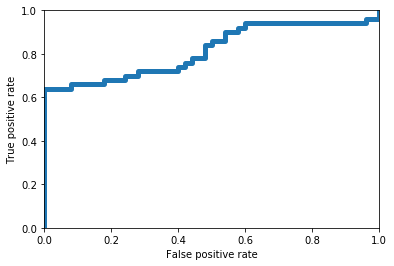

In [18]:
fpr, tpr, _ = roc_curve(join_df['class'], join_df.mi)
plt.plot(fpr, tpr, linewidth=5.0)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
